# Notebook for MVPA-GAT analysis

- create MVPA pipeline
- apply MVPA to epoched data
- stats on MVPA data
- visualize results

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("white")
sns.set_context('paper')

import mne
mne.set_log_level('ERROR')

import pandas as pd
import scipy.stats as stats
from os import listdir
import numpy as np
import pickle


df = pd.read_csv('/.../lookUp320.csv') # location of lookup csv

loc = "/.../n4-p6/"
template = loc + "{name}-on_ica-epo.fif" # location of epoched data
savs = "/.../" # a location to save results and figures

In [3]:
bads = ["VLA21", # not a native speaker of German
        "GMA05","RAC22","PBT16","HHA01","BSN17"]

In [4]:
names = list({fname.split("-")[0]  # the names of all datasets
              for fname in listdir(loc) 
              if "-raw" in fname and fname.split("-")[0] not in bads
             })

In [5]:
def get_epochs(name):
    '''
    loads the epoched data for participant (name)
    '''
    params = {"name":name}
    epoch = mne.read_epochs(template.format(**params))
    return epoch

times = get_epochs(names[0]).times # gets the array of time points for epoched data
l_times = list(times) # and creates a list

# Define functions

In [1]:
# Statistics tests used, thanks to Jean-Rémi King

def _my_wilcoxon(X):
    from scipy.stats import wilcoxon
    out = wilcoxon(X)
    return out[1]

def _loop(x, function):
    out = list()
    for ii in range(x.shape[1]):
        out.append(function(x[:, ii]))
    return out

def parallel_stats(X, function=_my_wilcoxon, correction='FDR', n_jobs=-1):
    from mne.parallel import parallel_func
    import numpy as np
    from mne.stats import fdr_correction

    if correction not in [False, None, 'FDR']:
        raise ValueError('Unknown correction')
    # reshape to 2D
    X = np.array(X)
    dims = X.shape
    X.resize([dims[0], np.prod(dims[1:])])
    # prepare parallel
    n_cols = X.shape[1]
    parallel, pfunc, n_jobs = parallel_func(_loop, n_jobs)
    n_chunks = min(n_cols, n_jobs)
    chunks = np.array_split(range(n_cols), n_chunks)
    p_values = parallel(pfunc(X[:, chunk], function) for chunk in chunks)
    p_values = np.reshape(np.hstack(p_values), dims[1:])
    X.resize(dims)
    # apply correction
    if correction == 'FDR':
        dims = p_values.shape
        _, p_values = fdr_correction(p_values)
        p_values = np.reshape(p_values, dims)
    return p_values

def _stat_fun(x, sigma=0, method='relative'):
    from mne.stats import ttest_1samp_no_p
    import numpy as np
    t_values = ttest_1samp_no_p(x, sigma=sigma, method=method)
    t_values[np.isnan(t_values)] = 0
    return t_values

def stats_tfce(X, n_permutations=2**10,threshold=dict(start=.1, step=.1), n_jobs=2):
    # threshold free cluster enhancement for GATs
    import numpy as np
    from mne.stats import spatio_temporal_cluster_1samp_test

    X = np.array(X)
    T_obs_, clusters, p_values, _ = spatio_temporal_cluster_1samp_test(
    X,out_type='mask',
    stat_fun=_stat_fun,
    n_permutations=n_permutations,
    threshold=threshold,
    n_jobs=n_jobs)
    p_values = p_values.reshape(X.shape[1:])
    return p_values

# GAT Decoding

In [13]:
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import StratifiedKFold

#from sklearn.model_selection import cross_val_multiscore # updated
from mne.decoding import SlidingEstimator, cross_val_multiscore, Scaler, Vectorizer
from mne.decoding import GeneralizingEstimator
import sklearn
from sklearn.pipeline import make_pipeline
from sklearn.metrics.scorer import make_scorer
from sklearn.metrics import roc_auc_score

def run_gat(name, decoder="ridge"):
    """
    Function to run Generalization Across Time (GAT).

    Parameters
    ----------
    name: str
        Name (pseudonym) of individual subject.    
    decoder: str
        Specify type of classifier -'ridge' for Ridge Regression (default),'lin-svm' for linear SVM 
        'svm' for nonlinear (RBF) SVM and 'log_reg' for Logistic Regression
    """
    # load high cloze epochs
    epochs = get_epochs(name)["hc"]

    # specify whether to use a linear or nonlinear SVM if SVM is used
    lin = '' # if not svm it doesn't matter, both log_reg and ridge are linear
    if "svm" in decoder:
        decoder, lin = decoder.split("-")
        
    ### build classifier pipeline ###
    # pick a machine learning algorithm to use (ridge/SVM/logistic regression)
    decoder_dict = {"ridge":RidgeClassifier(class_weight='balanced', random_state=42, solver="sag"),
                "svm":SVC(class_weight='balanced', kernel=("rbf" if "non" in lin else "linear"), random_state=42),
               "log_reg":LogisticRegression(class_weight='balanced', random_state=42)}
    
    clf = make_pipeline(StandardScaler(),
                    decoder_dict[decoder])
    gen_clf = GeneralizingEstimator(clf, scoring="roc_auc", n_jobs=5)
    scores = cross_val_multiscore(gen_clf, epochs.get_data(),
                                 epochs.events[:,-1],
                                 cv=5, 
                                 n_jobs=5).mean(0)
    
    labels = epochs.events[:, -1]
    data = epochs.get_data()
    cv = StratifiedKFold(labels, n_folds=5, random_state=42)
    
    # calculate prediction confidence scores
    preds = np.empty((len(labels), 161, 161))
    for train, test in cv:
        gen_clf.fit(data[train], labels[train])
        d = gen_clf.decision_function(data[test])
        preds[test] = d
    
    return scores, preds # return subject scores and prediction confidence

/data/home1/eheikel/tools/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [ ]:
%%capture
# Lets decode some stuff using 4 decoders! Or just comment out the ones you don't want to use:
# ridge (main one I am using here), non linear and linear SVM and logistic regression
# create dict of scores to reference the type of classifier and decoder accuracy scores/confidence scores

decoders = ["ridge", #"svm-nonlin", "svm-lin", "log_reg"
           ]

scores_dict = dict()
for d in decoders:
    scores_dict[d]=dict()
    scores_dict[d]["scores"] = []
    scores_dict[d]["predicts"] = []
    for name in names:
        score, predict = run_gat(name,decoder="ridge")
        scores_dict[d]["scores"].append(score)
        scores_dict[d]["predicts"].append(predict)
    

In [548]:
# save scores with pickle dump
with open(savs+'scores.pckl', 'wb') as fp:
    pickle.dump(scores_dict, fp)

In [36]:
# execute this cell to load previously calculated(and saved) scores
with open(savs+'scores.pckl', 'rb') as f:
        scores_dict = pickle.load(f)

In [15]:
def get_p_scores(scores, chance = .5, tfce=False):
    '''Calculate p_values from scores for significance masking using either TFCE or FDR
    Parameters
    ----------
    scores: numpy array
        Calulated scores from decoder
    chance: float
        Indicate chance level
    tfce: True | False
        Specify whether to Threshold Free Cluster Enhancement (True) or FDR (False)'''
    p_values = (parallel_stats(scores - chance) if tfce==False else stats_tfce(scores - chance))
    return p_values

In [20]:
def grouper(iterable):
    """List of time points of significance, identifies neighbouring time points"""
    prev = None
    group = []
    for item in iterable:
        if not prev or round(item - prev, 2) <= .01:
            group.append(item)
        else:
            yield group
            group = [item]
        prev = item
    if group:
        yield group
        
def find_clus(sig_times):
    """Identify time points of significance from FDR correction, results in lists of ranges and individual 
        time points of significance. Creates a dictionary for later use.
    
    Parameters
    ----------
    sig_times: list
        List of significant time points
    """
    group = dict(enumerate(grouper(sig_times)))
    clus = []
    for key in group.keys():   
        ls = group[key]
        clus.append((([ls[0], ls[-1]] if round((ls[1]-ls[0]), 2)<=0.01 else [ls[1], ls[-1]]) 
                     if len(group[key])>1 else group[key]))
    return clus


In [21]:
def get_stats_lines (scores, n4_times=[.3, 0.5], p6_times=[0.6, 0.8], alphas=[0.05, 0.01]):
    """Calculate subject level decoder performances for each of the times series plots and 
    perform FDR correction (p<0.05 and p<0.01). Creates a dictionary of relevant stats.
    
    Parameters
    ----------
    
    scores: array
    n4_times: list
        List of tmin and tmax for N400 time window
    p6_times: list
        List of tmin and tmax for P600 time window
    alphas: list
        List of alphas for significance masking default masks for p<0.05 and p<0.01
    """
    
    times = get_epochs(names[0]).times
    l_times, xx = list(times), np.meshgrid(times)[0]
    n4_min, n4_max, p6_min, p6_max = [l_times.index(t) for t in n4_times+p6_times]
    alpha1, alpha2 = alphas
    
    # average classifier performance over time for time window of interest for each subject
    n4 = scores[:, n4_min:n4_max, :].mean(1) 
    p6 = scores[:, p6_min:p6_max, :].mean(1)

    # FDR correction and significance testing
    n4_pvalues = parallel_stats(list(n4-0.5)) 
    p6_pvalues = parallel_stats(list(p6-0.5))

    # mask time points of significance that are p<0.05 (alpha1) and p<0.01 (alpha2)
    n1, n2  = xx[n4_pvalues<alpha1], xx[n4_pvalues<alpha2] 
    p1, p2  = xx[p6_pvalues<alpha1], xx[p6_pvalues<alpha2]

    # get the diagonal (training_t==testing_t) for each subject, FDR correction, and mask time points of significance
    diag = np.asarray([sc.diagonal() for sc in scores])
    diag_pvalues = parallel_stats(list(diag-0.5))
    diag1, diag2  = xx[diag_pvalues<alpha1], xx[diag_pvalues<alpha2]

    #average difference between classifier performance over time for time window of interest for each subject
    diff = np.array([(sc[p6_min:p6_max].mean(0) -
                          sc[n4_min:n4_max].mean(0)) # subtract N400 from P600 decoders
                         for sc in scores])
    #FDR correction and significance masking
    diff_pvalues = parallel_stats(list(diff))
    diff1, diff2  = xx[diff_pvalues<alpha1], xx[diff_pvalues<alpha2]
    
    #create dict of stats
    stats_dict = {"N400": [n4, n1, n2], "P600":[p6, p1, p2], "diag":[diag, diag1, diag2], "diff":[diff, diff1, diff2]}
    return stats_dict

In [22]:
def plot_image(data, times, mask=None, ax=None, vmax=None, vmin=None,
               draw_mask=None, draw_contour=None, colorbar=True,
               draw_diag=True, draw_zerolines=True, xlabel="Time (s)", ylabel="Time (s)",
               cbar_unit="%", cmap="RdBu_r", mask_alpha=.5, mask_cmap="RdBu_r"):
    """Return fig and ax for further styling of GAT matrix, e.g., titles
    
    Parameters
    ----------
    data: array of scores
    times: list of epoched time points
    mask: None | array
    ...
    """
    if ax is None:
        fig = plt.figure()
        ax = plt.axes()

    if vmax is None:
        vmax = np.abs(data).max()
    if vmin is None:
        vmax = np.abs(data).max()
        vmin = -vmax
    tmin, tmax = xlim = times[0], times[-1]
    extent = [tmin, tmax, tmin, tmax]
    im_args = dict(interpolation='nearest', origin='lower',
                   extent=extent, aspect='auto', vmin=vmin, vmax=vmax)

    if mask is not None:
        draw_mask = True if draw_mask is None else draw_mask
        draw_contour = True if draw_contour is None else draw_contour
    if any((draw_mask, draw_contour,)):
        if mask is None:
            raise ValueError("No mask to show!")

    if draw_mask:
        ax.imshow(data, alpha=mask_alpha, cmap=mask_cmap, **im_args)
        im = ax.imshow(np.ma.masked_where(~mask, data), cmap=cmap, **im_args)
    else:
        im = ax.imshow(data, cmap=cmap, **im_args)
    if draw_contour and np.unique(mask).size == 2:
        big_mask = np.kron(mask, np.ones((10, 10)))
        ax.contour(big_mask, colors=["k"], extent=extent, linewidths=[1],
                   aspect=1,
                   corner_mask=False, antialiased=False, levels=[.5])
    ax.set_xlim(xlim)
    ax.set_ylim(xlim)

    if draw_diag:
        ax.plot((tmin, tmax), (tmin, tmax), color="k", linestyle=":")
    if draw_zerolines:
        ax.axhline(0, color="k", linestyle=":")
        ax.axvline(0, color="k", linestyle=":")

    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)

    if colorbar:
        cbar = plt.colorbar(im, ax=ax)
        cbar.ax.set_title(cbar_unit)
    ax.set_aspect(1./ax.get_data_ratio())
    ax.set_title("GAT Matrix")
    
    return (fig if ax is None else ax)

In [23]:
def get_dfs(stats_dict, df_type=False):
    """Create DataFrames for time series plotting"""
    if not df_type:
        # create dataframe for N400 and P600 decoders
        df = pd.DataFrame()
        sub, time, accuracy, comp=[], [], [], []
        for c in ["N400", "P600"]:
            for ii, s in enumerate(stats_dict[c][0]):
                for t, a in enumerate(s):
                    sub.append(ii), accuracy.append(a), time.append(times[t]), comp.append(c)
        df["Time (s)"], df["Subject"], df["Accuracy (%)"], df["Component"] = time, sub, accuracy, comp
        
    else:
        # create dataframe for diagonal or difference between N400&P600
        sub, time, ac=[], [], []
        df = pd.DataFrame()
        for ii, s in enumerate(stats_dict[df_type][0]):
            for t, a in enumerate(s):
                sub.append(ii), ac.append(a), time.append(times[t])
        df["Time (s)"], df["Subject"] = time, sub
        df["{}".format(("Accuracy (%)" if df_type=="diag" else "Difference in Accuracy (%)"))] = ac
        
    return df

In [24]:
def over_plot(stats_dict, fill, axes=None, df_type=False):
    '''Plot line plots (component generalization, diagonal, component difference)'''
    if df_type=="diff":
        # plot difference between decoders
        plt_ = sns.tsplot(data=get_dfs(stats_dict, df_type=df_type), time="Time (s)", ax=axes, ci=[95], 
                          color="k", unit="Subject", condition=None, value="Difference in Accuracy (%)")
        
        plt_.title.set_text("Difference between N400 and P600 decoding performance across time")
        plt_.axvline(0, color="k", lw=0.5)
        plt_.axhline(0, color="k", lw=0.5)
        plt_.set_ylim(-0.08, 0.08)
        plt_.axvline(0.5, color="k", linestyle="--", lw=0.5)
        plt_.axvline(0.6, color="k", linestyle="--", lw=0.5)
        plt_.tick_params("both", labelsize=10)

        if fill:
            plt_.fill_betweenx([-0.8, 0.8], 0.3, 0.5, alpha=0.2, color="green")
            plt_.fill_betweenx([-0.8, 0.8], 0.6, 0.8, alpha=0.2, color="blue")
            
    else:
         
        if df_type=="diag": # plot diagonal
            plt_ = sns.tsplot(data=get_dfs(stats_dict, df_type=df_type), time="Time (s)", 
                              ci=[95], unit="Subject", condition=None,linestyle="--", 
                              value="Accuracy (%)", color="k", ax=axes)
        
        else: # component generalization
            plt_ = sns.tsplot(data=get_dfs(stats_dict, df_type), time="Time (s)", ax=axes,
                              ci=[95],  color=("green", "midnightblue"), unit="Subject", 
                              legend=True, condition="Component", value="Accuracy (%)")
        
        plt_.title.set_text(("Component generalization across time" 
                             if not df_type else "Diagonal decoding performance"))
        plt_.axvline(0, color="k", lw=0.5)
        plt_.axhline(0.5, color="k", lw=0.5)
        plt_.axvline(0.5, color="k", linestyle="--", lw=0.5)
        plt_.axvline(0.6, color="k", linestyle="--", lw=0.5)
        plt_.tick_params("both", labelsize=10)
        plt_.set_ylim(0.45, 0.62)
        if fill:
            plt_.fill_betweenx([0.45, 0.62], 0.3, 0.5, alpha=0.2, color="green")
            plt_.fill_betweenx([0.45, 0.62], 0.6, 0.8, alpha=0.2, color="blue")
    
    return plt_

In [25]:
def calc_xval(clus):
    """calculate xmin and xmax for axvlines to indicate time points of significance"""
    return {"xmin":(clus[0]+0.3)/1.6, "xmax":(clus[-1]+(0.3 if len(clus)!=1 else 0.301))/1.6}

def plot_results(stats_dict, scores, decoder="ridge", 
                 p_values=None, fill=True):
    '''Plotting results and masking for significance, thick lines index p<0.01 and thin lines p<0.05
    on time series plots, GAT is masked with TFCE and p<0.01'''
    
    fg, axes = plt.subplots(nrows=2, ncols=2)
    fg.set_size_inches(12, 8)
    fg.set_tight_layout("tight")
    times=get_epochs(names[0]).times
    
    ### Plot GAT matrix ###
    data = np.array(scores)
    plot_image(data.mean(0), times, mask=p_values<0.01, ax=axes[0, 0], vmax=.6, vmin=.4,
               draw_mask=True, draw_contour=True, colorbar=True,
               draw_diag=True, draw_zerolines=True, xlabel="Time (s)", ylabel="Time (s)",
               cbar_unit="%", cmap="RdBu_r", mask_alpha=.5, mask_cmap="RdBu_r");
    
    ### plot decoder performances trained at respective time windows (N4/P6) ##
    plt_gen = over_plot(stats_dict, fill , axes[1, 0])
    
    params = {"N400":{"val":0.47, "color":"green"}, "P600":{"val":0.48, "color":"midnightblue"}}
    # plot time points of significance according to FDR
    for key in params.keys():
        for it in [1, 2]: # Indicates whether p<0.01 or 0.05, respectively. Influence line thickness
            for clus in find_clus(stats_dict[key][it]):
                if type(clus)!=np.float64:
                    plt_gen.axhline(params[key]["val"], color=params[key]["color"], 
                                    lw=(1 if it==1 else 3), **calc_xval(clus))

    ### plot diagonal decoding performance ###
    plt_diag = over_plot(stats_dict, fill, axes[0, 1], "diag")
    for it in [1, 2]: # FDR 
        for clus in find_clus(stats_dict["diag"][it]):
            if type(clus)!=np.float64:
                plt_diag.axhline(0.47, color="k", linestyle="-", lw=(1 if it==1 else 3), 
                               **calc_xval(clus))
    
    ### plot difference between decoder performance in time windows ###
    plt_diff = over_plot(stats_dict, fill, axes[1, 1], "diff")
    for it in [1, 2]: #FDR
        for clus in find_clus(stats_dict["diff"][it]):
            if type(clus)!=np.float64:
                    plt_diff.axhline(-0.06, color=("green" if clus[-1] <.5 else "midnightblue"), 
                                     lw=(1 if it==1 else 3), **calc_xval(clus))
    return fg

# Decoding performance

GAT plots are TFCE (p<0.01), time series plots are FDR corrected (p<0.05, thin lines; p<0.01, thick lines)

/data/home1/eheikel/tools/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'aspect'
  s)
/data/home1/eheikel/tools/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
/data/home1/eheikel/tools/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


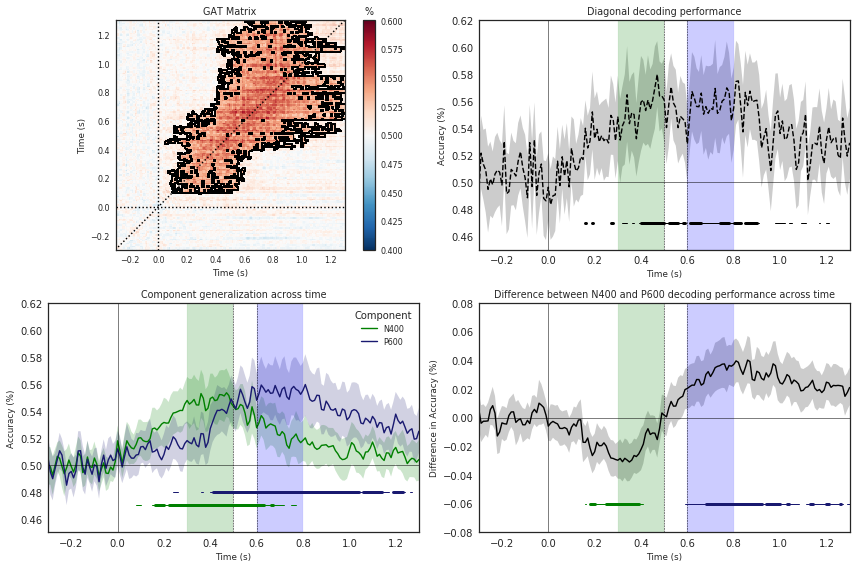

In [490]:
# thick lines index p<0.01
# thin lines index p<0.05
dec = "ridge"
scores = scores_dict[dec]["scores"].copy()

stats_dict = get_stats_lines(np.asarray(scores))

# to run TFCE on decoder scores
p_ = get_p_scores(scores, chance=.5, tfce=True) 

# plot GAT results
fg1 = plot_results(stats_dict, scores, 
                   decoder=dec, p_values=p_)

In [549]:
# save calculated p-values from TFCE (it takes a long time to compute) with pickle dump
with open(savs+'GAT_pvals.pckl', 'wb') as fp:
    pickle.dump(p_, fp)

In [491]:
fg1.savefig(savs + "gats.pdf")

# Subject level decoding performance

In [26]:
def sorted_by_subj(scores, tmin, tmax):
    tmin, tmax = l_times.index(tmin), l_times.index(tmax)
    order = scores[:, tmin:tmax].mean(1).argsort()
    trials = scores[order, :]
    return trials

In [27]:
def do_plot(ax, beta, ci, df,tim, cs = ["blue", "orange"]):
    c0, c1 = cs
    
    zero = list(times).index(0)
    vals = np.array([df.values[:, ii-15:ii].mean(1) - df.values[:, ii:ii+15].mean(1)
                     for ii, _ in enumerate(df.columns)])[zero:-zero].T
    #sns.tsplot(vals, ax=ax, time=times[zero-1:-zero], legend=False, color=c1)

    ax.plot(times, beta, color=c0, label="ROC AUC ~ (index * 10)")
    #ax.plot(times[zero-1:-zero], vals.mean(0), color=c1, label="Diff. pre/post ROC AUC\n(150 msec time window)")
    ax.fill_between(times, *ci.T, alpha=.3, color=c0)

    ax.set_ylabel("ROC AUC")
    ax.set_yticks([-.04, -.02, 0, .02, .04, .06])
    ax.set_ylim((-.045, .085))
    ax.set_xlim((times[0], times[-1]))
    ax.axhline(0, linestyle=":", color="grey")
    ax.axvline(0, linestyle="-", color="grey")
    ax.set_xticks([])
    sns.despine(trim=True, ax=ax, bottom=False)
    
    return vals

In [28]:
def get_data(data, ax, tim):
    import statsmodels.formula.api as smf
    df = pd.DataFrame(data) - .5
    df.columns = ["t" + str(x) for x in df.columns]
    tmin, tmax = times[0], times[-1]
    im = ax.imshow(df.values, cmap="RdBu_r", extent=(tmin, tmax, 0, 10), aspect='auto', 
                   interpolation="bicubic", vmin=-.25, vmax=.25)
    ax.set_yticks([])
    ax.axvline(0, linestyle="-", color="grey")
    for t_ in tim:
        ax.axvline(t_, linestyle="--", color="k")
        
    df.index /= 10
    df.reset_index(inplace=True)
    ci = np.array([smf.ols("t{} ~ index".format(ii), data=df).fit().conf_int().loc["index"].values
                      for ii, _ in enumerate(df.columns[1:])])
    beta = np.array([smf.ols("t{} ~ index".format(ii), data=df).fit().params.loc["index"]
                      for ii, _ in enumerate(df.columns[1:])])

    return df, beta, ci, im

In [37]:
scores = scores_dict["ridge"]["scores"].copy()
stats_dict = get_stats_lines(np.asarray(scores))

time_win = [[0.3, 0.5], [0.6, 0.8]]
component = ['N400', 'P600']

di = dict()
for tim, comp in zip(time_win, component):
    di["N400" if comp=="N400" else "P600"] = sorted_by_subj(stats_dict[comp][0], tim[0], tim[1])

/data/home1/eheikel/tools/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice.
  
/data/home1/eheikel/tools/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Text(0,0.5,'ROC AUC > chance')

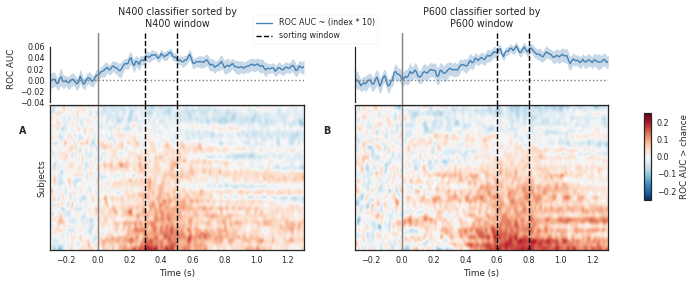

In [38]:
fg2, axes = plt.subplots(ncols=2, nrows=1, sharex=True)
fg2.set_size_inches((10, 4))
from mpl_toolkits.axes_grid1 import make_axes_locatable
time_win = [[0.3, 0.5], [0.6, 0.8],
           ]
component = ['N400', 'P600']
axes = axes.flatten()

for ii, tim, comp, letter in zip((0, 1,), time_win, component, "AB"):
    ax_heat = axes[ii]
    data = di[comp]
    divider = make_axes_locatable(ax_heat)
    ax_ts = divider.append_axes("top", size="50%")

    df, beta, ci, im = get_data(data, ax_heat, tim)
    vals = do_plot(ax_ts, beta, ci, df, tim, cs=["steelblue", "darkorange"])
    if ax_heat.is_last_row():
        ax_heat.set_xlabel("Time (s)")
    if not ax_heat.is_first_col():
        ax_ts.set_ylabel("")
        ax_ts.set_yticklabels([])
    else:
        ax_heat.set_ylabel("Subjects")
    ax_ts.set_title('{} classifier sorted by\n{} window'.format(comp, comp))
    ax_ts.axvline(tim[0], linestyle="--", color="k")
    ax_ts.axvline(tim[-1], linestyle="--", color="k", label="sorting window")
    ax_heat.text(-.5, 8, letter, fontweight="bold")

ax_ts.legend(loc=(-.4, .85), frameon=True)

cbar_ax = fg2.add_axes((.95, .3, .01, .3))
plt.colorbar(im, cax=cbar_ax)
cbar_ax.set_ylabel("ROC AUC > chance")

In [486]:
fg2.savefig(savs+"subject_level.pdf")